In [1]:
from Network import *
from DriveSim import *

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#시뮬레이션 학습 코드
if __name__ == '__main__':
    wins = 0
    n_runs = 10000
    agent = Agent(lr=0.003, gamma=0.99, n_actions=5, batch_size=64, epsilon=1.0, input_dims=[6])
    sim = DriveSimulator()
    train_scores = []
    epsilons = []
    avg_score = 0.0
    for i in range(n_runs):
        over = False
        sim.reset(frame_rate=300)

        state = sim.get_sim_state()
        while not over:
            action = agent.choose_action(state)
            state_, stpRwd, sim_over = sim.step(action)
            over = sim_over

            agent.store_transition(state, action, stpRwd, state_, over)
            state = state_

        agent.learn()
        agent.epsilon = 1.0 - (float(i)/float(n_runs))
        #scores.append(sim.agtRwd)
        
        avg_score += sim.agtRwd
        if sim.episode_count % 100 == 0:
            print('Episode', sim.episode_count, ', average score(last 100 episodes):', avg_score/100, 'wins:', sim.win_count, 'eps:', agent.epsilon)
            train_scores.append(avg_score/100)
            epsilons.append(agent.epsilon)
            avg_score = 0.0

    agent.save_model('./models/q_20220926')

q_next weight set!
Episode 100 , average score(last 100 episodes): -9.412449148044002 wins: 19 eps: 0.9901
q_next weight set!
Episode 200 , average score(last 100 episodes): -7.966735894891064 wins: 38 eps: 0.9801
q_next weight set!
Episode 300 , average score(last 100 episodes): -8.023858732009947 wins: 55 eps: 0.9701
q_next weight set!
Episode 400 , average score(last 100 episodes): -8.928295691156874 wins: 76 eps: 0.9601
q_next weight set!
Episode 500 , average score(last 100 episodes): -9.055565355440415 wins: 87 eps: 0.9501
q_next weight set!
Episode 600 , average score(last 100 episodes): -8.112481992422294 wins: 99 eps: 0.9401
q_next weight set!
Episode 700 , average score(last 100 episodes): -7.338114980311937 wins: 113 eps: 0.9301
q_next weight set!
Episode 800 , average score(last 100 episodes): -9.61015786726454 wins: 124 eps: 0.9201
q_next weight set!
Episode 900 , average score(last 100 episodes): -8.92424209606784 wins: 138 eps: 0.9101
q_next weight set!
Episode 1000 , av

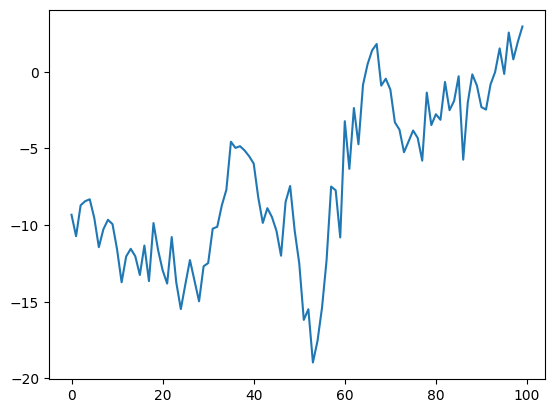

In [3]:
plt.plot(train_scores)

In [7]:
print(agent.q_eval.Aw.kernal)

ListWrapper([0.017, 0.728, 0.0026, 0.119, 0.134])


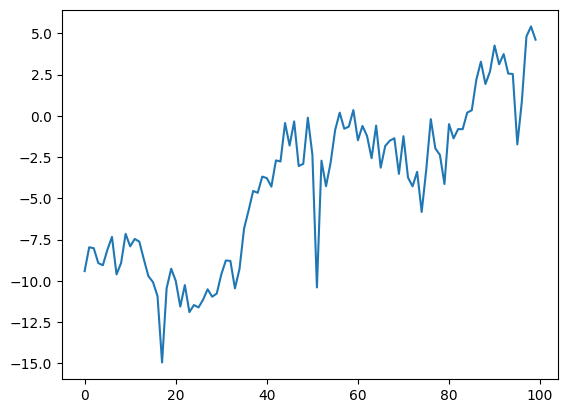

In [3]:
plt.plot(train_scores)


In [ ]:
#학습 결과 테스트
if __name__ == '__main__':
    wins = 0
    test_runs = 100

    sim = DriveSimulator()
    scores = []
    epsilons = []
    for i in range(test_runs):
        over = False
        sim.reset(frame_rate=30)

        state = sim.get_sim_state()
        while not over:
            action = agent.choose_action(state)
            state_, stpRwd, sim_over = sim.step(action)
            over = sim_over
            state = state_

        scores.append(sim.agtRwd)
        print('Episode', sim.episode_count, ', score:', sim.agtRwd, 'wins:', sim.win_count, 't:', sim.t)
    x = [i + 1 for i in range(test_runs)]
    plt.plot(x, scores)
    plt.show()

loaded weights from ./models/q_20220926
Episode 1 , score: 2.6538274694101647 wins: 1 t: 88
Episode 2 , score: -5.185969822123604 wins: 1 t: 44
Episode 3 , score: 8.774308387527414 wins: 2 t: 89
Episode 4 , score: 3.213470812404015 wins: 3 t: 88
Episode 5 , score: 4.415758888964451 wins: 4 t: 87
Episode 6 , score: 8.825191778604376 wins: 5 t: 95
Episode 7 , score: 9.26896847026266 wins: 6 t: 92
Episode 8 , score: -5.2924999999999995 wins: 6 t: 44
Episode 9 , score: 6.197576456159284 wins: 7 t: 84
Episode 10 , score: 8.774308387527414 wins: 8 t: 89
Episode 11 , score: 2.6538274694101647 wins: 9 t: 88
Episode 12 , score: -5.287928841750083 wins: 9 t: 44
Episode 13 , score: -5.185969822123604 wins: 9 t: 44
Episode 14 , score: 3.967158698647916 wins: 10 t: 92
Episode 15 , score: 7.037341429661285 wins: 11 t: 91
Episode 16 , score: 9.138940596247528 wins: 12 t: 91
Episode 17 , score: 3.467872922815248 wins: 13 t: 89
Episode 18 , score: 8.73591874116277 wins: 14 t: 94
Episode 19 , score: 1.5

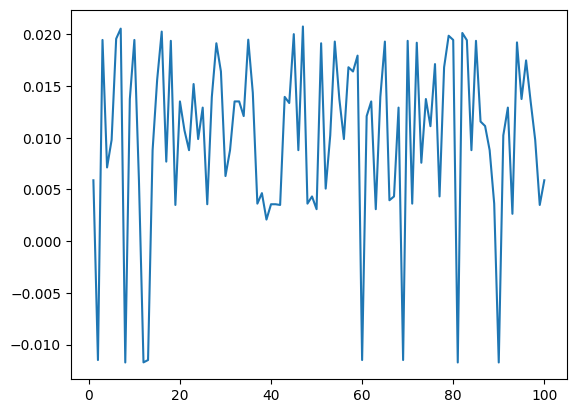

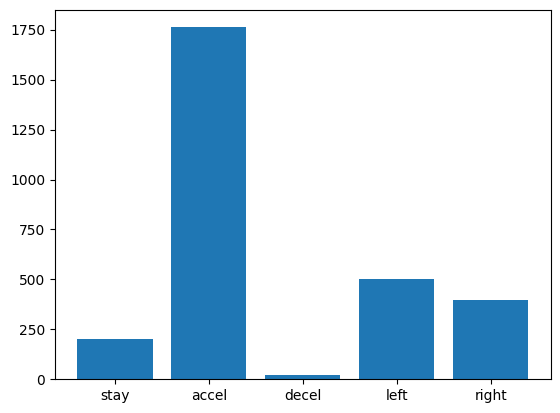

In [5]:
#학습된 정책의 action 분포 측정
if __name__ == '__main__':
    test_agent = Agent(lr=0.0005, gamma=0.99, n_actions=5, batch_size=64, epsilon=0, input_dims=[6])
    test_agent.load_model('./models/q_20220926')
    wins = 0
    test_runs = 100

    sim = DriveSimulator()
    scores = []
    epsilons = []
    stats = [0,0,0,0,0]
    for i in range(test_runs):
        over = False
        sim.reset(frame_rate=30)

        state = sim.get_sim_state()
        while not over:
            action = test_agent.choose_action(state)
            stats[action] += 1
            state_, stpRwd, sim_over = sim.step(action)
            over = sim_over
            state = state_

        scores.append(sim.agtRwd)
        print('Episode', sim.episode_count, ', score:', sim.agtRwd, 'wins:', sim.win_count, 't:', sim.t)
    x = [i + 1 for i in range(test_runs)]
    plt.plot(x, scores / np.sum(scores,axis=0))
    plt.show()

    plt.bar(['stay','accel', 'decel', 'left', 'right'], stats)
    plt.show()



In [8]:
print(stats)

#0.017 0.728 0.0026 0.119 0.134
#0.0701 0.0611 0.0065 0.1748 0.1370

[202, 1762, 19, 504, 395]
